# Late Fusion adapted by Transfer Squeeze Net

We will implement late fusion which is introduced in paper "Large-scale Video Classification with Convolutional Neural Network" 

The pipeline will be described in detail as below.

First, we will clip 5 frames from a video that we want to classify. 

Second, we will pass the 5 frames individually through trained squeeze net on image net to get a 1000 result which is used in image net label.

Third, we will concatinate 5 1000 result together to train another FC layer to give the labels that we want to classify our video. 

Above all, we will implement these late fusion approach and fine tune hyperparameters to yeild the best possbile result

# load Squeeze Net model and other libraries

In [7]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import json

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataset and preprocess
 - First, run DataProprocessing Notebook to get label (Y) and data (X) txt file. 
 - Second, move label and data txt file into this notebook foler
 - third, run the code below

In [11]:
def get_data(num_training = 40, num_validation = 10, num_test = 10):
    ''' 
    load the training data provided by Jake 
    
    '''
#     # load the raw data
#     with open('label_squeeze.json', 'r') as fp:
#         y_total = json.load(fp)
#         y_total = np.array(y_total)
#     with open('data_squeeze.json', 'r') as fp:
#         x_total = json.load(fp)
#         x_total = np.array(x_total)

    x_total = np.load("data_5_frame_test.npy")
    y_total = np.load("label_5_frame_test.npy")
        
    # Subsample the data
    # training data
    mask_train = range(0, num_training)
    x_train = x_total[mask_train]
    y_train = y_total[mask_train]
    # validation data
    mask_val = range(num_training, num_training + num_validation)
    x_val = x_total[mask_val]
    y_val = y_total[mask_val]
    # test data
    mask_test = range(num_training+num_validation, num_training+num_validation+num_test)
    x_test = x_total[mask_test]
    y_test = y_total[mask_test]
    
    # normalize the data: subtract the mean
    mean_video = np.floor(np.mean(x_train, axis=0))
    x_train = x_train - mean_video
    x_val = x_val - mean_video
    x_test = x_test - mean_video
    
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_data()

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (40, 5, 224, 224, 3)
Train labels shape:  (40,)
Validation data shape:  (10, 5, 224, 224, 3)
Validation labels shape:  (10,)
Test data shape:  (10, 5, 224, 224, 3)
Test labels shape:  (10,)


# define to train the last layer

In [5]:
tf.reset_default_graph()
sess = get_session()
SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

NUM_CLASSES = 4 
FRAME_PER_VIDEO = tf.constant(5, dtype='int32')

with tf.variable_scope('classifier_squeeze_frame'):
    with tf.variable_scope('layer0'):
        x = model.features
        dims = tf.shape(x)
        N,H,W,C = dims[0], dims[1], dims[2], dims[3]
        x = tf.reshape(x, [tf.to_int32(N/FRAME_PER_VIDEO), H, W, C*FRAME_PER_VIDEO]) 
    with tf.variable_scope('layer1'):
        W = tf.get_variable("weights",shape=[1,1,2560,NUM_CLASSES])
        b = tf.get_variable("bias",shape=[NUM_CLASSES])
        x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
        x = tf.nn.bias_add(x,b)
    with tf.variable_scope('layer2'):
        x = tf.nn.relu(x)
    with tf.variable_scope('layer3'):
        x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,13,13,1],padding='VALID')
        
model.classifier = tf.reshape(x,[-1, NUM_CLASSES])
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(model.labels, NUM_CLASSES), logits=model.classifier))
classifier_squeeze_variable = tf.contrib.framework.get_variables('classifier_squeeze_frame')
optimizer = tf.train.AdamOptimizer(1) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss, var_list = classifier_squeeze_variable)

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


# define run model

In [38]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=40, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), model.labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
    
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            X_batch = Xd[idx,:]
            N,F,H,W,C = X_batch.shape
            X_batch_reshape = np.reshape(X_batch, [N*F,H,W,C])
            feed_dict = {model.image: X_batch_reshape,
                         model.labels: yd[idx]}
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# train the model

Iteration 0: with minibatch training loss = 1.38 and accuracy of 0.1
Epoch 1, Overall loss = 71.2 and accuracy of 0.296


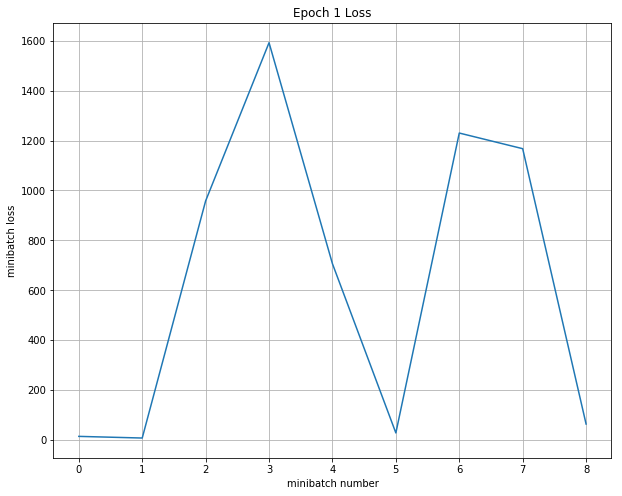

Epoch 2, Overall loss = 31.8 and accuracy of 0.593


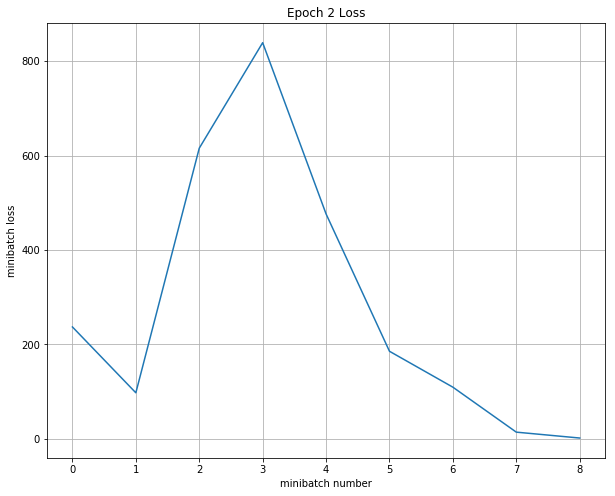

Epoch 3, Overall loss = 1.39 and accuracy of 0.593


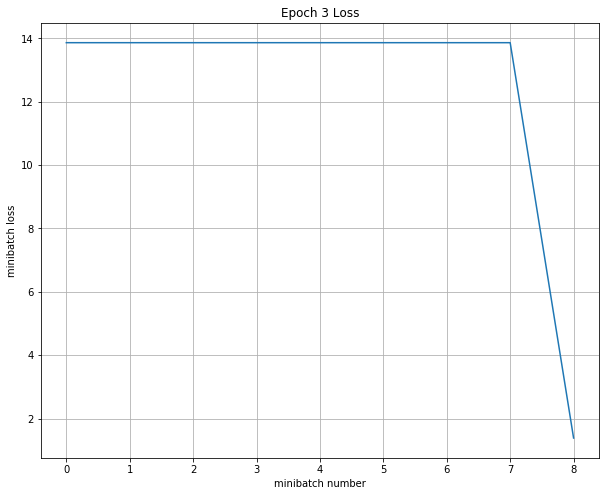

Epoch 4, Overall loss = 1.39 and accuracy of 0.593


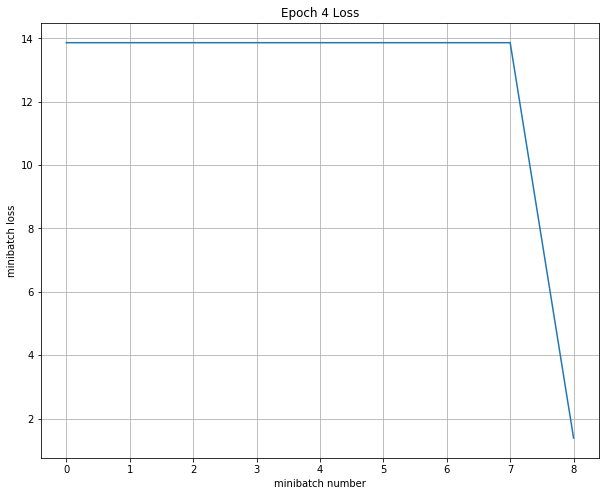

Epoch 5, Overall loss = 1.39 and accuracy of 0.593


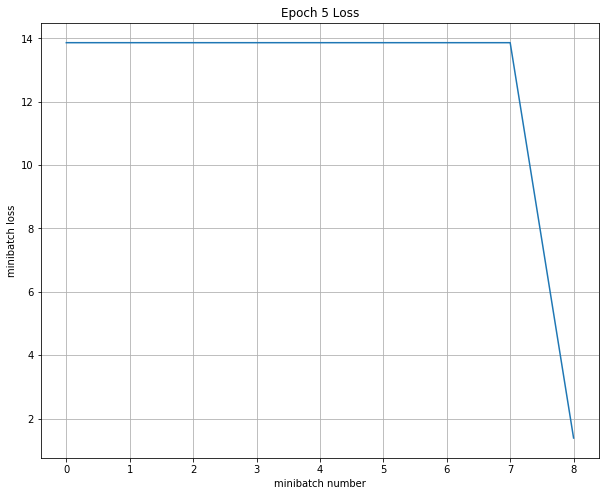

Epoch 6, Overall loss = 1.39 and accuracy of 0.593


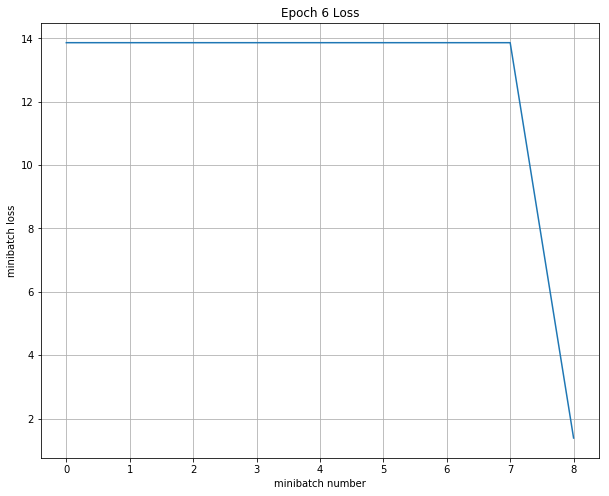

Epoch 7, Overall loss = 1.39 and accuracy of 0.593


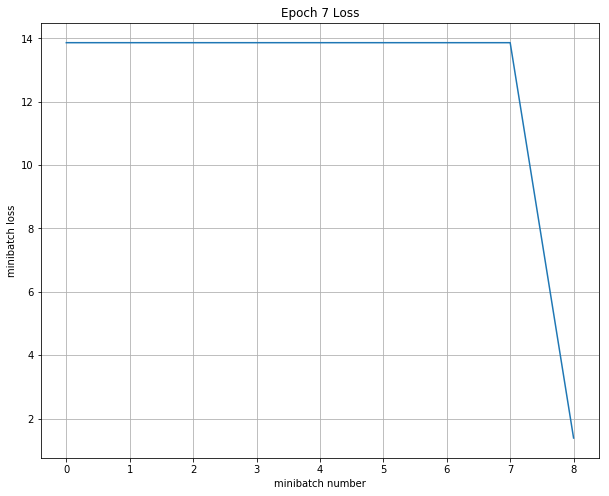

Epoch 8, Overall loss = 1.39 and accuracy of 0.593


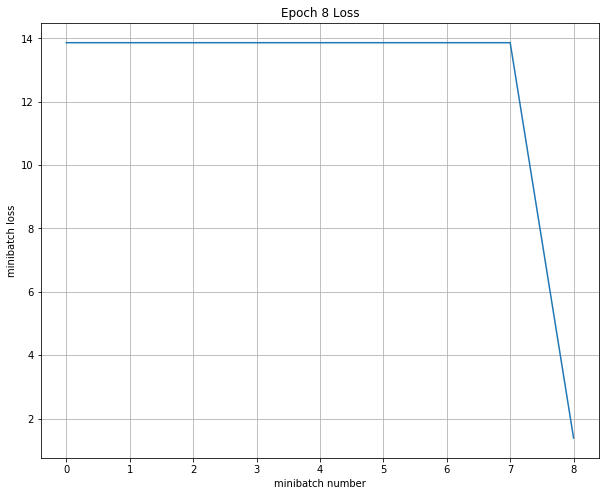

Epoch 9, Overall loss = 1.39 and accuracy of 0.593


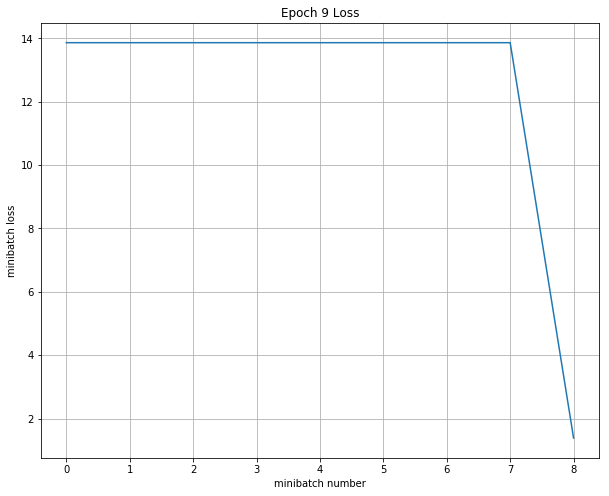

Epoch 10, Overall loss = 1.39 and accuracy of 0.593


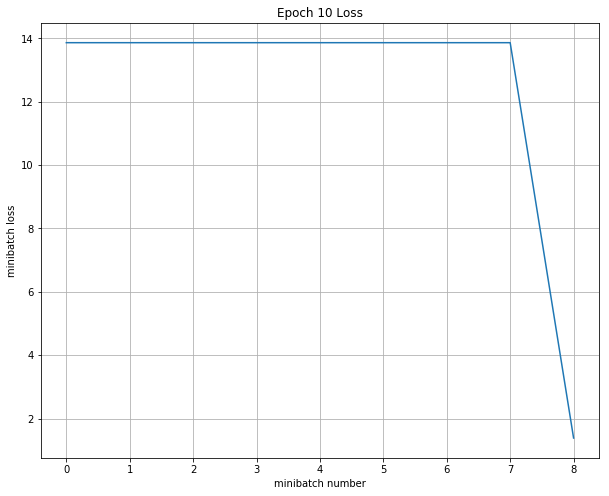

(1.3862943649291992, 0.59259259259259256)

In [39]:
# print('Training')
sess.run(tf.global_variables_initializer())
run_model(sess,model.classifier,mean_loss,x_train,y_train,10,10,100,train_step,True)

# validate the model

In [40]:
print('Validation')
run_model(sess,model.classifier,mean_loss,x_val,y_val,1,10)

Validation
Epoch 1, Overall loss = 1.39 and accuracy of 0.5


(1.3862943649291992, 0.5)

In [41]:
# test the model
print('Test')
run_model(sess,model.classifier,mean_loss,x_test,y_test,1,10)

Test
Epoch 1, Overall loss = 1.39 and accuracy of 0.6


(1.3862943649291992, 0.59999999999999998)